In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV

In [2]:
df  = pd.read_csv('../data/train_set.csv')

In [3]:
def convert_to_time(df, cols):
    df[cols] = df[cols].apply(pd.to_datetime)
    return df

def convert_to_string(df, cols):
    df[cols] = df [cols].astype('str')
    return df

def convert_to_category(df, cols):
    df[cols] = df [cols].astype('category')
    return df

def estadisticas_categoricas(xtrain, ytrain, variable):
    df = pd.DataFrame(xtrain.join(ytrain).groupby(variable).target.mean()).reset_index()
    df.columns = [str(variable[0]),str(variable[0] + '_media_target')]
    df[str(variable[0] + '_mediana_target')] = pd.DataFrame(xtrain.join(ytrain).groupby(variable).target.median()).reset_index()['target']
    df[str(variable[0] + '_std_target')] = pd.DataFrame(xtrain.join(ytrain).groupby(variable).target.std()).reset_index()['target']
    return df

def create_time_variables(df):
    df['total_wait_time'] = (df['order_delivered_customer_date'] - df['order_purchase_timestamp']).dt.days
    df['aproved_wait_time'] = (df['order_aproved_at'] - df['order_purchase_timestamp']).dt.days
    df['estimated_wait_time'] = (df['order_estimated_delivery_date'] - df['order_delivered_customer_date']).dt.days
    df['arrived_hour'] = df['order_delivered_customer_date'].dt.hour
    df['arrived_day'] = df['order_delivered_customer_date'].dt.day
    df['arrived_week_day'] = df['order_delivered_customer_date'].dt.dayofweek
    df['arrived_month'] = 'month_' + (df['order_delivered_customer_date'].dt.month).astype(str)
#    df['arrived_month'] = df['order_delivered_customer_date'].dt.month
    df['arrived_quarter'] = 'quarter_' + (df['order_delivered_customer_date'].dt.quarter).astype(str)
    df['purchase_week_day'] = df['order_purchase_timestamp'].dt.dayofweek
    df['purchase_hour'] = df['order_purchase_timestamp'].dt.hour
    df['purchase_month'] = df['order_purchase_timestamp'].dt.month
    df['aproved_week_day'] = df['order_aproved_at'].dt.dayofweek
    df['aproved_month'] = df['order_aproved_at'].dt.month
    df['aproved_hour'] = df['order_aproved_at'].dt.hour

    return df

In [4]:
def clean_categories(df, column, umbral, flag_mode):
    df[column] = df[column].str.lower().str.strip().str.replace(' ', '_')
    df_aux = df[column].value_counts(True).to_frame()
    df_aux[f'clean_{column}'] = np.where(df_aux[column] < umbral, "small_cat_" + column, df_aux.index)
    mode = df_aux.head(1)[f'clean_{column}'].values[0]

    df_result = df.merge(df_aux.drop(column, axis = 1).reset_index(), left_on = column, right_on = 'index', how = 'left').drop('index', axis = 1)
    if flag_mode == True:
        df_result[f'clean_{column}'] = df_result[f'clean_{column}'].fillna(mode)

    df_aux = df_aux.drop(column, axis = 1).reset_index()
    df_aux.columns = [column,f'clean_{column}']
    return df_result, df_aux, mode

In [5]:
df, df_order , mode_order = clean_categories(df, column = 'order_status', umbral = 0.05, flag_mode = True)
df, df_product, mode_product = clean_categories(df, column = 'product_category_name_english', umbral = 0.02, flag_mode = True)
df, df_city, mode_city = clean_categories(df, column = 'customer_city', umbral = 0.02, flag_mode = True)
df, df_state, mode_state = clean_categories(df, column = 'customer_state', umbral = 0.05, flag_mode = True)

In [6]:
cols = ['order_purchase_timestamp', 'order_aproved_at', 
        'order_estimated_delivery_date', 'order_delivered_customer_date']
cols_string = ['order_status', 'customer_city', 'customer_state', 
               'product_category_name_english']
df = convert_to_time(df, cols)
df = create_time_variables(df)

In [7]:
df = pd.get_dummies(
    df, 
    columns = 
        ['clean_order_status'
         , 'clean_product_category_name_english'
         , 'clean_customer_city'
         , 'clean_customer_state'
         , 'arrived_week_day'
         , 'arrived_month'
        # ,'arrived_quarter'
        ], drop_first=True, prefix='_')

In [8]:
df = df[df.columns.drop(list(df.filter(regex='clean_')))]

In [9]:
list(df.filter(regex='__'))

['__small_cat_order_status',
 '__baby',
 '__bed_bath_table',
 '__computers_accessories',
 '__cool_stuff',
 '__fashion_bags_accessories',
 '__furniture_decor',
 '__garden_tools',
 '__health_beauty',
 '__housewares',
 '__perfumery',
 '__small_cat_product_category_name_english',
 '__sports_leisure',
 '__telephony',
 '__toys',
 '__watches_gifts',
 '__brasilia',
 '__rio_de_janeiro',
 '__sao_paulo',
 '__small_cat_customer_city',
 '__pr',
 '__rj',
 '__rs',
 '__small_cat_customer_state',
 '__sp',
 '__1.0',
 '__2.0',
 '__3.0',
 '__4.0',
 '__5.0',
 '__6.0',
 '__month_10.0',
 '__month_11.0',
 '__month_12.0',
 '__month_2.0',
 '__month_3.0',
 '__month_4.0',
 '__month_5.0',
 '__month_6.0',
 '__month_7.0',
 '__month_8.0',
 '__month_9.0',
 '__month_nan']

In [10]:
x = df.drop(['target', 'ID'],axis=1)
y = df.target

In [11]:
xtrain, xtest, ytrain, ytest=train_test_split(x, y, random_state=12, 
             test_size=0.30)

In [12]:
gbr = GradientBoostingRegressor(n_estimators=600, 
    max_depth=5, 
    learning_rate=0.01, 
    min_samples_split=3)

gbr = XGBRegressor()


In [13]:
producto = estadisticas_categoricas(xtrain, ytrain, ['product_category_name_english'])
xtrain = xtrain.merge(producto, how='left')
xtest = xtest.merge(producto, how='left')

In [14]:
entrega = estadisticas_categoricas(xtrain, ytrain, ['order_status'])
xtrain = xtrain.merge(entrega, how='left')
xtest = xtest.merge(entrega, how='left')

In [15]:
x_train = pd.get_dummies(xtrain['order_status'])#,  drop_first = True)
x_test = pd.get_dummies(xtest['order_status'])#,  drop_first = True)

x_test = x_test.reindex(columns = x_train.columns, fill_value=0)
xtrain = x_train.join(xtrain.drop('order_status', axis=1))
xtest = x_test.join(xtest.drop('order_status', axis=1))

In [16]:
estado = estadisticas_categoricas(xtrain, ytrain, ['customer_state'])
xtrain = xtrain.merge(estado, how='left')
xtest = xtest.merge(estado, how='left')


In [17]:
xtrain.columns

Index(['canceled', 'delivered', 'invoiced', 'processing', 'shipped',
       'unavailable', 'order_products_value', 'order_freight_value',
       'order_items_qty', 'order_sellers_qty', 'order_purchase_timestamp',
       'order_aproved_at', 'order_estimated_delivery_date',
       'order_delivered_customer_date', 'customer_city', 'customer_state',
       'customer_zip_code_prefix', 'product_category_name_english',
       'product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'total_wait_time', 'aproved_wait_time',
       'estimated_wait_time', 'arrived_hour', 'arrived_day', 'arrived_quarter',
       'purchase_week_day', 'purchase_hour', 'purchase_month',
       'aproved_week_day', 'aproved_month', 'aproved_hour',
       '__small_cat_order_status', '__baby', '__bed_bath_table',
       '__computers_accessories', '__cool_stuff', '__fashion_bags_accessories',
       '__furniture_decor', '__garden_tools', '__health_beauty',
       '__housewares', '__perfumery',
    

In [18]:
cols = [ 
    'order_products_value', #
    'order_freight_value'
    ,'product_description_lenght' #
    ,'product_name_lenght' #
    ,'product_photos_qty' #
    ,'order_items_qty'
    ,'order_sellers_qty'
    ,'total_wait_time'
    ,'aproved_wait_time'
    ,'estimated_wait_time'
    ,'arrived_hour'
    ,'arrived_day'
#    ,'arrived_week_day'
#    ,'canceled'
#    ,'delivered'
#    ,'invoiced'	
#    ,'processing'	
#    ,'shipped'	
#    ,'unavailable'
    ,'product_category_name_english_media_target'
#    ,'product_category_name_english_mediana_target'
#    ,'product_category_name_english_std_target'
    ,'order_status_media_target'
#    ,'order_status_mediana_target'
#    ,'order_status_std_target'
    ,'customer_state_media_target'
#    ,'customer_state_mediana_target'
    ,'customer_state_std_target'
#    ,'arrived_month'
#    ,'arrived_quarter'
    ,'purchase_week_day'
    ,'purchase_hour'
    ,'purchase_month'
    ,'aproved_week_day'
    ,'aproved_month'
    ,'aproved_hour'
]
cols.extend(list(df.filter(regex='__')))
len(cols)

65

In [19]:
gbr.fit(xtrain[cols], ytrain)
ypredtrain = gbr.predict(xtrain[cols])
ypred = gbr.predict(xtest[cols])

print('R2 en train: {:.4f}'.format(r2_score(ytrain, ypredtrain)))
print('R2 en test : {:.4f}'.format(r2_score(ytest, ypred)))

R2 en train: 0.5129
R2 en test : 0.2262


In [21]:
ypred[ypred<1] = 1
ypred[ypred>5] = 5
ypredtrain[ypredtrain<1] = 1
ypredtrain[ypredtrain>5] = 5

print('R2 en train: {:.4f}'.format(r2_score(ytrain, ypredtrain)))
print('R2 en test : {:.4f}'.format(r2_score(ytest, ypred)))

R2 en train: 0.5131
R2 en test : 0.2273


In [41]:
gbm_param_grid

{'n_estimators': [100, 200, 400],
 'max_depth': [3, 5, 7],
 'eta': [0.1, 0.3, 0.5, 0.9],
 'subsample': [0.3, 0.5, 0.7],
 'colsample_bytree': [0.3, 0.5, 0.7]}

In [92]:
gbm_param_grid = {
    'n_estimators': [1000],
    'max_depth': [7],
    "eta":[0.01],
    'subsample': [0.7],
    'colsample_bytree':[0.6],
    'lambda': [1, 1.1 1.3],
    'alpha': [1e-2, 0.1, 1]
}

In [97]:
randomized_mse.best_estimator_.get_xgb_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.6,
 'eval_metric': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 7,
 'max_leaves': None,
 'min_child_weight': None,
 'monotone_constraints': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': 0.7,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None,
 'seed': 2705,
 'lambda': 1,
 'eta': 0.01,
 'alpha': 0.1}

In [94]:
gbm = XGBRegressor(objective='reg:squarederror',seed=2705)
randomized_mse = RandomizedSearchCV(estimator = gbm,param_distributions = gbm_param_grid, 
                                    scoring = "r2", n_iter = 50, cv = 4, verbose = 1, n_jobs=-2)
randomized_mse.fit(xtrain[cols], ytrain)

ypred = randomized_mse.predict(xtest[cols])
ypredtrain = randomized_mse.predict(xtrain[cols])

print('R2 en train: {:.4f}'.format(r2_score(ytrain, ypredtrain)))
print('R2 en test : {:.4f}'.format(r2_score(ytest, ypred)))

Fitting 4 folds for each of 50 candidates, totalling 200 fits
R2 en train: 0.4291
R2 en test : 0.2664


In [98]:
randomized_mse.best_estimator_

XGBRegressor(alpha=0.1, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, early_stopping_rounds=None,
             enable_categorical=False, eta=0.01, eval_metric=None,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None, lambda=1,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=1000, n_jobs=None, ...)

In [96]:
ypred[ypred<1] = 1
ypred[ypred>5] = 5
ypredtrain[ypredtrain<1] = 1
ypredtrain[ypredtrain>5] = 5

print('R2 en train: {:.4f}'.format(r2_score(ytrain, ypredtrain)))
print('R2 en test : {:.4f}'.format(r2_score(ytest, ypred)))

R2 en train: 0.4291
R2 en test : 0.2664


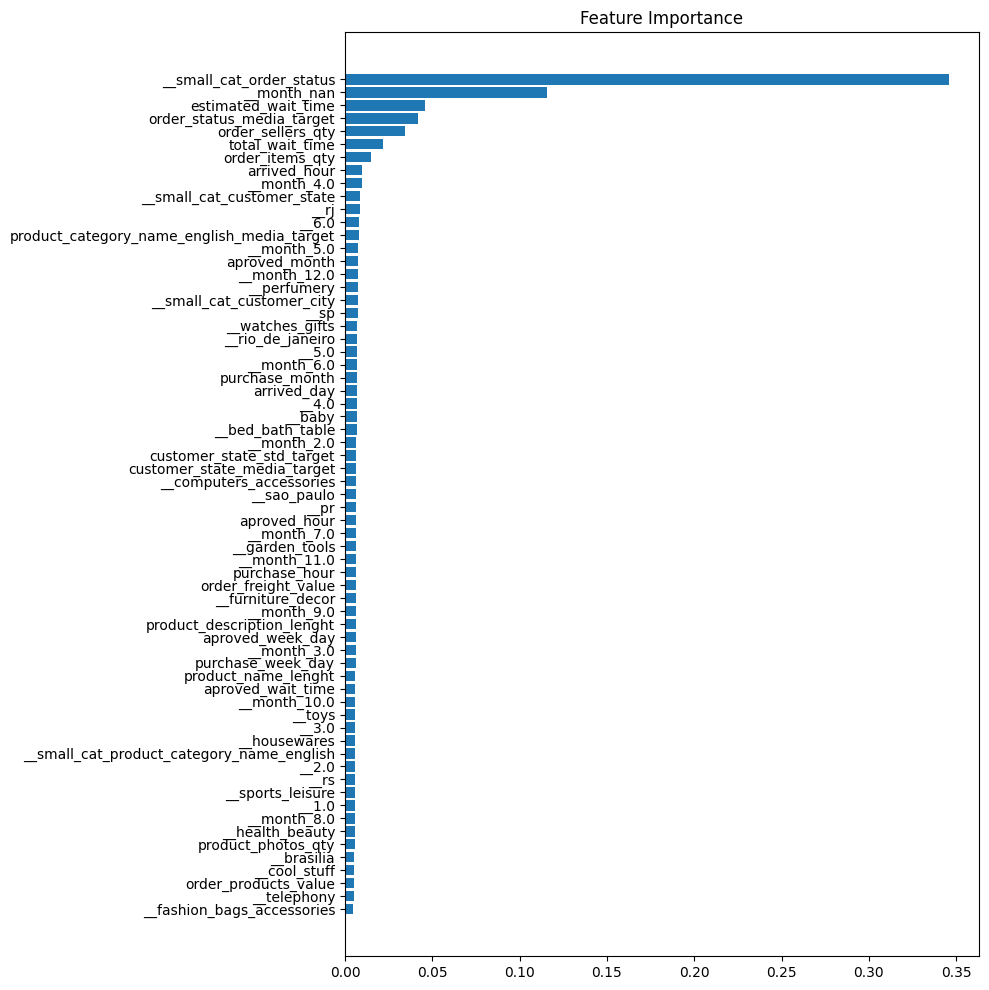

In [99]:
feature_importance = randomized_mse.best_estimator_.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(18, 12))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(xtrain[cols].columns)[sorted_idx])
plt.title("Feature Importance")

plt.show()

In [100]:
predecir = pd.read_csv('../data/test_set.csv')
predecir.head()

,ID,order_status,order_products_value,order_freight_value,order_items_qty,order_sellers_qty,order_purchase_timestamp,order_aproved_at,order_estimated_delivery_date,order_delivered_customer_date,customer_city,customer_state,customer_zip_code_prefix,product_category_name_english,product_name_lenght,product_description_lenght,product_photos_qty
0,0,delivered,30.00,28.20,2.0,1.0,2017-06-22 20:28:16.000000,2017-06-22 20:42:51.013492,2017-07-14 00:00:00.000000,2017-09-19 15:17:37.767855,NaN,SP,48.0,health_beauty,17.0,547.0,1.0
1,1,delivered,89.90,12.33,1.0,1.0,NaN,2017-11-20 23:34:44.641435,2017-12-01 00:00:00.000000,2017-11-23 14:41:51.640086,Caieiras,SP,NaN,bed_bath_table,58.0,188.0,1.0
2,2,delivered,890.00,86.71,1.0,1.0,2018-02-12 12:31:32.000000,2018-02-15 03:55:50.384756,2018-03-09 00:00:00.000000,2018-02-27 15:19:06.698500,Sao Caetano do Sul,SP,95.0,health_beauty,57.0,537.0,1.0
3,3,delivered,85.00,17.84,1.0,NaN,2017-07-24 05:21:16.000000,NaN,2017-08-15 00:00:00.000000,2017-07-31 19:42:27.819239,Curitiba,PR,813.0,stationery,56.0,303.0,3.0
4,4,delivered,168.98,25.31,1.0,1.0,2018-03-29 22:20:33.000000,2018-03-29 22:30:18.256631,NaN,2018-05-15 15:05:44.342452,Aracaju,SE,490.0,bed_bath_table,60.0,496.0,2.0


In [101]:
def feature_enginering(df, df_producto, df_entrega, df_estado):
    
    cols = ['order_purchase_timestamp', 'order_aproved_at', 
            'order_estimated_delivery_date', 'order_delivered_customer_date']
    df = convert_to_time(df, cols)
    df = create_time_variables(df)
    df = df.merge(df_producto, how='left')
    df = df.merge(df_entrega, how = 'left')
    df = df.merge(df_estado, how = 'left')
    df_c = df.reindex(columns = x_train.columns, fill_value=0)
    df = df_c.join(df.drop('order_status', axis=1))
    return df

In [102]:
predecir = predecir.merge(df_order, how='left')
predecir = predecir.merge(df_city, how='left')
predecir = predecir.merge(df_product, how='left')
predecir = predecir.merge(df_state, how='left')

In [103]:
predecir

,ID,order_status,order_products_value,order_freight_value,order_items_qty,order_sellers_qty,order_purchase_timestamp,order_aproved_at,order_estimated_delivery_date,order_delivered_customer_date,...,customer_state,customer_zip_code_prefix,product_category_name_english,product_name_lenght,product_description_lenght,product_photos_qty,clean_order_status,clean_customer_city,clean_product_category_name_english,clean_customer_state
0,0,delivered,30.00,28.20,2.0,1.0,2017-06-22 20:28:16.000000,2017-06-22 20:42:51.013492,2017-07-14 00:00:00.000000,2017-09-19 15:17:37.767855,...,SP,48.0,health_beauty,17.0,547.0,1.0,delivered,NaN,health_beauty,NaN
1,1,delivered,89.90,12.33,1.0,1.0,NaN,2017-11-20 23:34:44.641435,2017-12-01 00:00:00.000000,2017-11-23 14:41:51.640086,...,SP,NaN,bed_bath_table,58.0,188.0,1.0,delivered,NaN,bed_bath_table,NaN
2,2,delivered,890.00,86.71,1.0,1.0,2018-02-12 12:31:32.000000,2018-02-15 03:55:50.384756,2018-03-09 00:00:00.000000,2018-02-27 15:19:06.698500,...,SP,95.0,health_beauty,57.0,537.0,1.0,delivered,NaN,health_beauty,NaN
3,3,delivered,85.00,17.84,1.0,NaN,2017-07-24 05:21:16.000000,NaN,2017-08-15 00:00:00.000000,2017-07-31 19:42:27.819239,...,PR,813.0,stationery,56.0,303.0,3.0,delivered,NaN,small_cat_product_category_name_english,NaN
4,4,delivered,168.98,25.31,1.0,1.0,2018-03-29 22:20:33.000000,2018-03-29 22:30:18.256631,NaN,2018-05-15 15:05:44.342452,...,SE,490.0,bed_bath_table,60.0,496.0,2.0,delivered,NaN,bed_bath_table,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13795,13795,delivered,NaN,14.58,1.0,1.0,2018-01-15 16:45:54.000000,2018-01-15 17:31:05.148146,2018-02-06 00:00:00.000000,2018-01-22 21:28:36.253866,...,SP,46.0,perfumery,29.0,190.0,1.0,delivered,NaN,perfumery,NaN
13796,13796,delivered,89.90,27.36,1.0,1.0,2018-04-20 17:07:28.000000,2018-04-24 18:13:25.435518,2018-05-17 00:00:00.000000,NaN,...,MG,301.0,sports_leisure,56.0,1381.0,4.0,delivered,NaN,sports_leisure,NaN
13797,13797,delivered,49.80,16.54,2.0,1.0,2017-05-15 16:34:31.000000,2017-05-15 16:45:20.862091,2017-05-26 00:00:00.000000,2017-05-17 14:57:48.201245,...,SP,122.0,sports_leisure,47.0,1070.0,1.0,delivered,NaN,sports_leisure,NaN
13798,13798,delivered,69.00,14.79,1.0,1.0,2018-06-28 22:54:44.000000,2018-06-28 23:11:02.212383,2018-07-18 00:00:00.000000,NaN,...,SP,15.0,bed_bath_table,59.0,NaN,1.0,delivered,NaN,bed_bath_table,NaN


In [104]:
predecir['clean_order_status'] = predecir['clean_order_status'].fillna(mode_order)
predecir['clean_customer_city'] = predecir['clean_customer_city'].fillna(mode_city)
predecir['clean_product_category_name_english'] = predecir['clean_product_category_name_english'].fillna(mode_product)
predecir['clean_customer_state'] = predecir['clean_customer_state'].fillna(mode_state)

In [105]:
predecir = feature_enginering(predecir, producto, entrega, estado)
predecir.head()

,canceled,delivered,invoiced,processing,shipped,unavailable,ID,order_products_value,order_freight_value,order_items_qty,...,aproved_hour,product_category_name_english_media_target,product_category_name_english_mediana_target,product_category_name_english_std_target,order_status_media_target,order_status_mediana_target,order_status_std_target,customer_state_media_target,customer_state_mediana_target,customer_state_std_target
0,0,0,0,0,0,0,0,30.00,28.20,2.0,...,20.0,4.186776,5.0,1.268793,4.038443,5.0,1.378823,NaN,NaN,NaN
1,0,0,0,0,0,0,1,89.90,12.33,1.0,...,23.0,3.935175,5.0,1.414043,4.038443,5.0,1.378823,NaN,NaN,NaN
2,0,0,0,0,0,0,2,890.00,86.71,1.0,...,3.0,4.186776,5.0,1.268793,4.038443,5.0,1.378823,NaN,NaN,NaN
3,0,0,0,0,0,0,3,85.00,17.84,1.0,...,NaN,4.157182,5.0,1.261994,4.038443,5.0,1.378823,NaN,NaN,NaN
4,0,0,0,0,0,0,4,168.98,25.31,1.0,...,22.0,3.935175,5.0,1.414043,4.038443,5.0,1.378823,NaN,NaN,NaN


In [106]:
predecir = pd.get_dummies(
    predecir, 
    columns = 
        ['clean_order_status'
         , 'clean_product_category_name_english'
         , 'clean_customer_city'
         , 'clean_customer_state'
         , 'arrived_week_day'
         , 'arrived_month'
        # ,'arrived_quarter'
        ], drop_first=True, prefix='_')
predecir

,canceled,delivered,invoiced,processing,shipped,unavailable,ID,order_products_value,order_freight_value,order_items_qty,...,__month_12.0,__month_2.0,__month_3.0,__month_4.0,__month_5.0,__month_6.0,__month_7.0,__month_8.0,__month_9.0,__month_nan
0,0,0,0,0,0,0,0,30.00,28.20,2.0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,1,89.90,12.33,1.0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,2,890.00,86.71,1.0,...,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,3,85.00,17.84,1.0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,4,168.98,25.31,1.0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13795,0,0,0,0,0,0,13795,NaN,14.58,1.0,...,0,0,0,0,0,0,0,0,0,0
13796,0,0,0,0,0,0,13796,89.90,27.36,1.0,...,0,0,0,0,0,0,0,0,0,1
13797,0,0,0,0,0,0,13797,49.80,16.54,2.0,...,0,0,0,0,1,0,0,0,0,0
13798,0,0,0,0,0,0,13798,69.00,14.79,1.0,...,0,0,0,0,0,0,0,0,0,1


In [107]:
for i in cols:
    if i not in predecir:
        predecir[i] = 0

In [108]:
target = randomized_mse.predict(predecir[cols])
target[target<1] = 1
target[target>5] = 5
predecir['target'] = target
predecir.head()

,canceled,delivered,invoiced,processing,shipped,unavailable,ID,order_products_value,order_freight_value,order_items_qty,...,__brasilia,__rio_de_janeiro,__sao_paulo,__small_cat_customer_city,__pr,__rj,__rs,__small_cat_customer_state,__sp,target
0,0,0,0,0,0,0,0,30.00,28.20,2.0,...,0,0,0,0,0,0,0,0,0,2.162518
1,0,0,0,0,0,0,1,89.90,12.33,1.0,...,0,0,0,0,0,0,0,0,0,4.254623
2,0,0,0,0,0,0,2,890.00,86.71,1.0,...,0,0,0,0,0,0,0,0,0,4.349763
3,0,0,0,0,0,0,3,85.00,17.84,1.0,...,0,0,0,0,0,0,0,0,0,4.458999
4,0,0,0,0,0,0,4,168.98,25.31,1.0,...,0,0,0,0,0,0,0,0,0,2.370983


In [109]:
predecir[['ID','target']].to_csv('../data/sum_07_R2_267.csv', index=False)

In [110]:
predecir.shape

(13800, 87)